# Ungraded Lab: Implement a Siamese network

This lab will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing. For Week 1, you will just focus on constructing the network. You will revisit this lab in Week 2 when we talk about custom loss functions.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [5]:
train_images /= 255.0
test_images /= 255.0

In [6]:
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

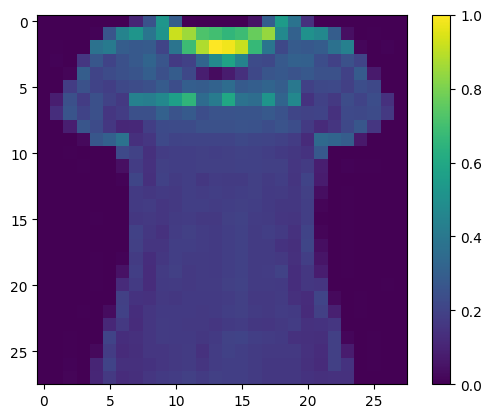

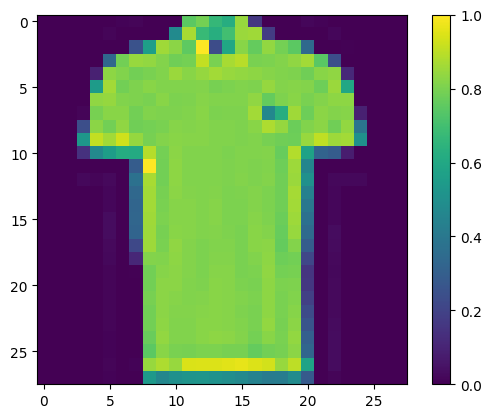

1.0


In [7]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

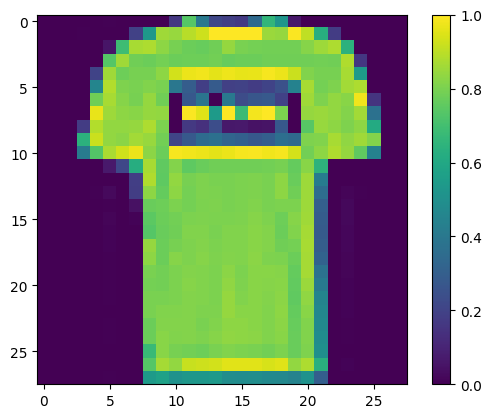

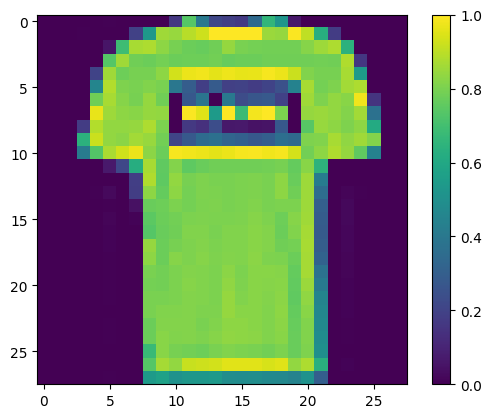

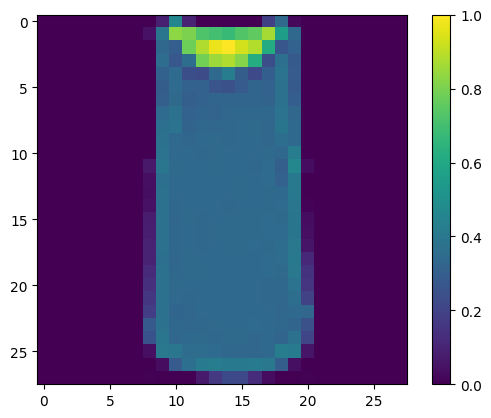

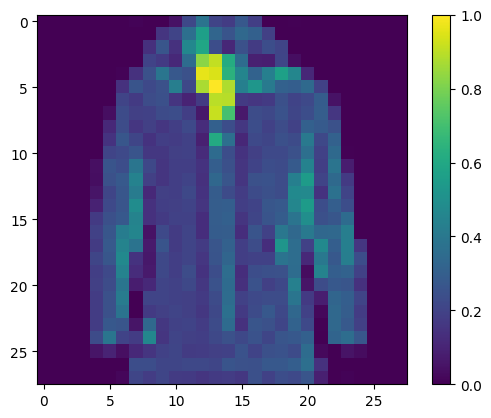

In [8]:
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Build the Model

Next, you'll define some utilities for building our model.

In [9]:
def initialize_base_network():
    input = Input(shape=(28, 28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation="relu", name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation="relu", name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation="relu", name="third_base_dense")(x)
    return Model(inputs=input, outputs=x)


def euclidian_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, _ = shapes
    return (shape1[0], 1)

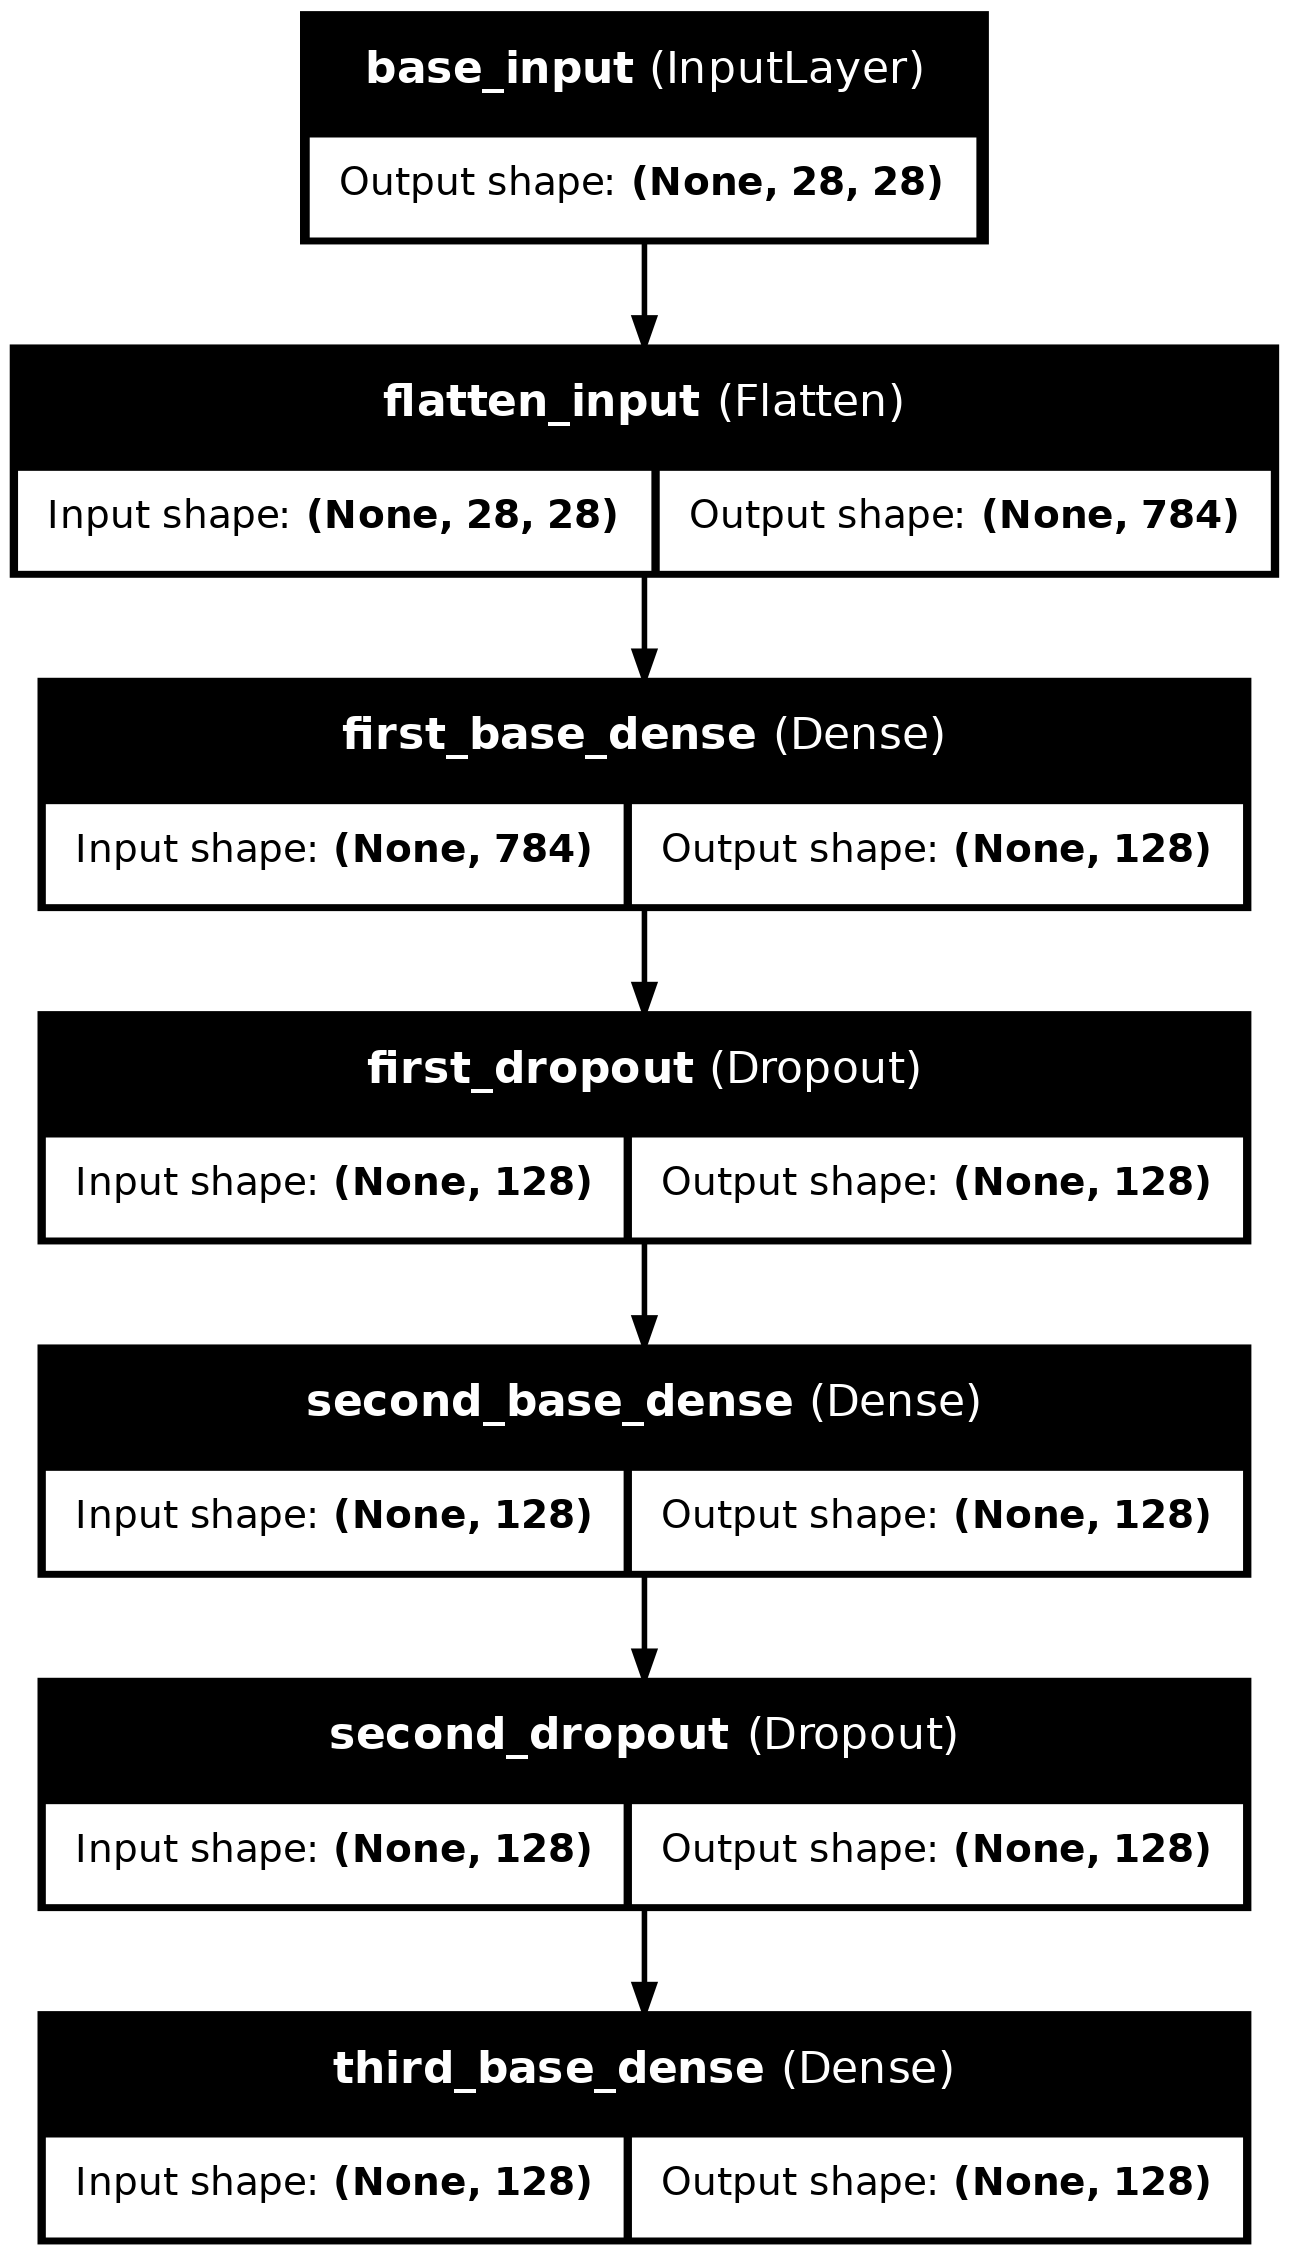

In [12]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file="base-model.png")

In [13]:
input_a = Input(shape=(28, 28), name="left_input")
vect_output_a = base_network(input_a)

In [14]:
input_b = Input(shape=(28, 28), name="right_input")
vect_output_b = base_network(input_b)

In [15]:
output = Lambda(euclidian_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

In [16]:
model = Model([input_a, input_b], output)

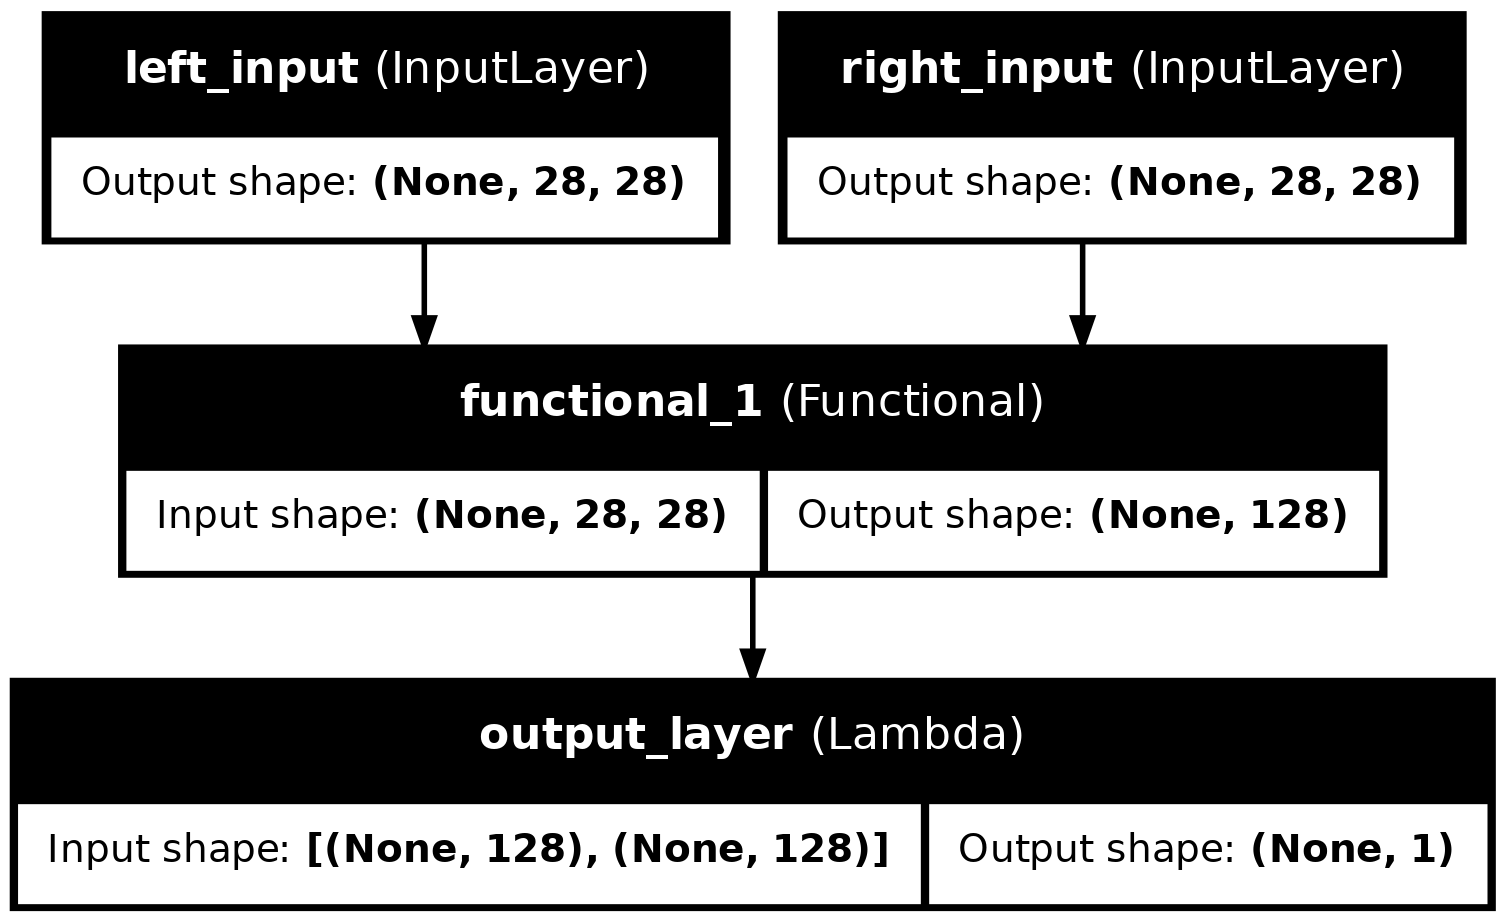

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="outer_model.png")

## Train the Model

You can now define the custom loss for our network and start training.

In [18]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)

    return contrastive_loss

In [19]:
rms = RMSprop()

In [20]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [ ]:
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

Epoch 1/20


I0000 00:00:1737837512.108163  895193 service.cc:148] XLA service 0x7fbae8015d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737837512.108770  895193 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-25 20:38:32.161152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737837512.331602  895193 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-25 20:38:33.629960: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 24 bytes spill loads

2025-01-25 20:38:33.777139: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 24 byte

 62/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3145

I0000 00:00:1737837516.200784  895193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1455 - val_loss: 0.0904
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0852 - val_loss: 0.0815
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0759 - val_loss: 0.0744
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0706 - val_loss: 0.0702
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0669 - val_loss: 0.0700
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0645 - val_loss: 0.0674
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0620 - val_loss: 0.0701
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0611 - val_loss: 0.0649
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0593 - val_loss: 0.0668
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0581 - val_loss: 0.0633
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0568 - val_loss: 0.0656
Epoch 12/20
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

## Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [ ]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)